In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'): 
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from nltk.corpus import stopwords
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Flatten,Dropout,BatchNormalization,Embedding,Input,TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

# Data Preprocess

In [59]:
all_data=[]
Articles_with_stopwords=[]
Articles_without_stopwords=[]
Summaries=[]
stop_words=set(stopwords.words('english'))
for d,path,filenames in tqdm(os.walk('/kaggle/input')):
    for file in filenames:
        if os.path.isfile(d+'/'+file):
            if('Summaries' in d+'/'+file):
                with open(d+'/'+file,'r',errors='ignore') as f:
                    summary=''.join([i.rstrip() for i in f.readlines()])
                    Summaries.append(summary)
                    f.close()
            else:
                with open(d+'/'+file,'r',errors='ignore') as f:
                    Article=''.join([i.rstrip() for i in f.readlines()])
                    Articles_with_stopwords.append(Article)
                    Articles_without_stopwords.append(' '.join([w for w in Article.split() if w not in stop_words]))
                    f.close()
        
                    

29it [00:11,  2.44it/s]


In [60]:
print(len(Articles_with_stopwords),len(Articles_without_stopwords),len(Summaries))

4450 4450 4450


In [61]:
data=pd.DataFrame({'Articles without stop words':Articles_without_stopwords,'Article with stop words': Articles_with_stopwords,'Summary':Summaries})
data.head()

,Articles without stop words,Article with stop words,Summary
0,Budget set scene electionGordon Brown seek put...,Budget to set scene for electionGordon Brown w...,- Increase in the stamp duty threshold from £6...
1,Army chiefs regiments decisionMilitary chiefs ...,Army chiefs in regiments decisionMilitary chie...,"""They are very much not for the good and will ..."
2,Howard denies split ID cardsMichael Howard den...,Howard denies split over ID cardsMichael Howar...,Michael Howard has denied his shadow cabinet w...
3,Observers monitor UK electionMinisters invite ...,Observers to monitor UK electionMinisters will...,The report said individual registration should...
4,Kilroy names election seat targetEx-chat show ...,Kilroy names election seat targetEx-chat show ...,"UKIP's leader, Roger Knapman, has said he is g..."


In [62]:
data['Articles without stop words'][0]

'Budget set scene electionGordon Brown seek put economy centre Labour\'s bid third term power delivers ninth Budget 1230 GMT. He expected stress importance continued economic stability, low unemployment interest rates. The chancellor expected freeze petrol duty raise stamp duty threshold £60,000. But Conservatives Lib Dems insist voters face higher taxes means-testing Labour.Treasury officials said pre-election giveaway, Mr Brown thought £2bn spare.- Increase stamp duty threshold £60,000 - A freeze petrol duty - An extension tax credit scheme poorer families - Possible help pensioners The stamp duty threshold rise intended help first time buyers - likely theme three main parties\' general election manifestos. Ten years ago, buyers much greater chance avoiding stamp duty, close half million properties, England Wales alone, selling less £60,000. Since then, average UK property prices doubled starting threshold stamp duty increased. Tax credits As result, number properties incurring stamp

In [63]:
for i in range(5):
    print(data['Article with stop words'][i])
    print("---------------------------------------------")

Budget to set scene for electionGordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about £2bn to spare.- Increase in the stamp duty threshold from £60,000 - A freeze on petrol duty - An extension of tax credit scheme for poorer families - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a much greater chance of avoiding stamp duty

In [64]:
data['Summary'][0]

'- Increase in the stamp duty threshold from £60,000 - A freeze on petrol duty - An extension of tax credit scheme for poorer families - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties\' general election manifestos.The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000.The Tories are also thought likely to propose increased thresholds, with shadow chancellor Oliver Letwin branding stamp duty a "classic Labour stealth tax".Tax credits As a result, the number of properties incurring stamp duty has rocketed as has the government\'s tax take.Since then, average UK property prices have more than doubled while the starting threshold for stamp duty has not increased.For the Lib Dems David Laws said: "The chancellor will no doubt tell us today how wonderfully the economy is doing," he said.The Liberal Democrats unveiled their own proposals to raise the st

## Text Cleaning

In [65]:
import re

In [66]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [67]:
def clean_text(text):
    
    text=text.lower()
    text=' '.join([contraction_mapping[i] if i in contraction_mapping.keys() else i for i in text.split()])
    text=re.sub(r'\(.*\)',"",text)
    text=re.sub("'s","",text)
    text=re.sub('"','',text)
    text=' '.join([i for i in text.split() if i.isalpha()])
    text=re.sub('[^a-zA-Z]'," ",text)
    
    return text

In [68]:
data['Article with stop words']=data['Article with stop words'].apply(clean_text)
data['Articles without stop words']=data['Articles without stop words'].apply(clean_text)
data['Summary']=data['Summary'].apply(clean_text)
data['Summary']='<START> '+data['Summary']+' <END>'

In [69]:
data['Article with stop words'][0]

'budget to set scene for electiongordon brown will seek to put the economy at the centre of labour bid for a third term in power when he delivers his ninth budget at he is expected to stress the importance of continued economic with low unemployment and interest the chancellor is expected to freeze petrol duty and raise the stamp duty threshold from but the conservatives and lib dems insist voters face higher taxes and more under officials have said there will not be a but mr brown is thought to have about to increase in the stamp duty threshold from a freeze on petrol duty an extension of tax credit scheme for poorer families possible help for pensioners the stamp duty threshold rise is intended to help first time buyers a likely theme of all three of the main general election ten years buyers had a much greater chance of avoiding stamp with close to half a million in england and wales selling for less than since average uk property prices have more than doubled while the starting thr

In [70]:
data['Articles without stop words'][0]

'budget set scene electiongordon brown seek put economy centre labour bid third term power delivers ninth budget he expected stress importance continued economic low unemployment interest the chancellor expected freeze petrol duty raise stamp duty threshold but conservatives lib dems insist voters face higher taxes officials said mr brown thought increase stamp duty threshold a freeze petrol duty an extension tax credit scheme poorer families possible help pensioners the stamp duty threshold rise intended help first time buyers likely theme three main general election ten years buyers much greater chance avoiding stamp close half million england wales selling less since average uk property prices doubled starting threshold stamp duty tax credits as number properties incurring stamp duty rocketed government tax the liberal democrats unveiled proposals raise stamp duty threshold tories also thought likely propose increased shadow chancellor oliver letwin branding stamp duty classic labou

In [71]:
data['Summary'][0]

'<START> increase in the stamp duty threshold from a freeze on petrol duty an extension of tax credit scheme for poorer families possible help for pensioners the stamp duty threshold rise is intended to help first time buyers a likely theme of all three of the main general election chancellor is expected to freeze petrol duty and raise the stamp duty threshold from tories are also thought likely to propose increased with shadow chancellor oliver letwin branding stamp duty a classic labour stealth credits as a the number of properties incurring stamp duty has rocketed as has the government tax average uk property prices have more than doubled while the starting threshold for stamp duty has not the lib dems david laws the chancellor will no doubt tell us today how wonderfully the economy is he liberal democrats unveiled their own proposals to raise the stamp duty threshold to in labour is elected there will be a very substantial tax increase in the budget after the of the order of around

## Train Val Split

In [72]:
X_train,X_val,Y_train,Y_val=train_test_split(data['Article with stop words'],data['Summary'],test_size=0.3,random_state=29)
print(len(X_train),len(Y_train))
print(len(X_val),len(Y_val))

3115 3115
1335 1335


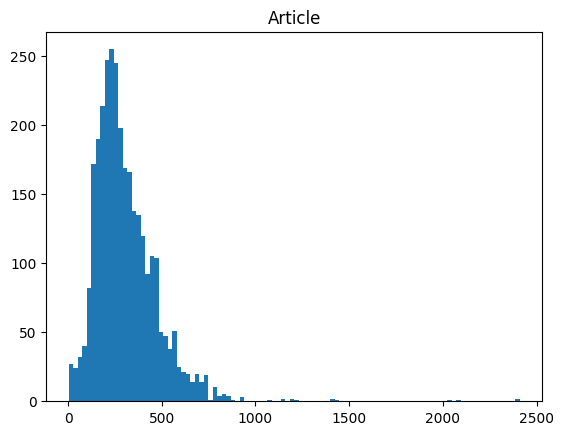

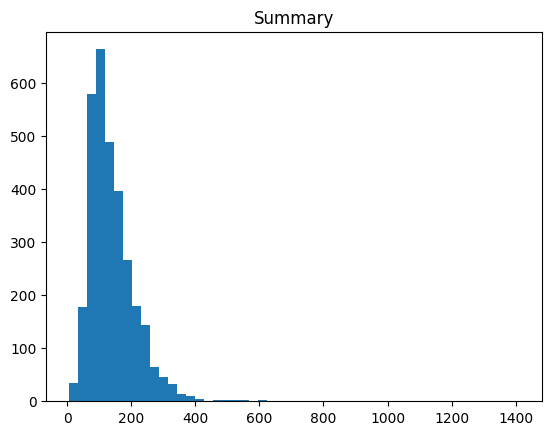

In [73]:
art_len=[len(i.split()) for i in X_train]
sum_len=[len(i.split()) for i in Y_train]
plt.hist(art_len,bins=100)
plt.title('Article')
plt.show()
plt.hist(sum_len,bins=50)
plt.title('Summary')
plt.show()

In [74]:
max_art_len=500
max_sum_len=100

## Vectorization

In [75]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [76]:
article_tokenizer=Tokenizer(oov_token='<UNK>')
article_tokenizer.fit_on_texts(X_train)
tokenized_X_train=article_tokenizer.texts_to_sequences(X_train)
tokenized_X_val=article_tokenizer.texts_to_sequences(X_val)

In [77]:
art_vocab_size=len(article_tokenizer.word_index)+1

In [78]:
padded_X_train=pad_sequences(tokenized_X_train,maxlen=max_art_len,padding='post',truncating='post')
padded_X_val=pad_sequences(tokenized_X_val,maxlen=max_art_len,padding='post',truncating='post')

In [79]:
print(padded_X_train.shape,padded_X_val.shape)

(3115, 500) (1335, 500)


In [80]:
summary_tokenizer=Tokenizer(oov_token='<UNK>')
summary_tokenizer.fit_on_texts(Y_train)
tokenized_Y_train=summary_tokenizer.texts_to_sequences(Y_train)
tokenized_Y_val=summary_tokenizer.texts_to_sequences(Y_val)

In [81]:
sum_vocab_size=len(summary_tokenizer.word_index)+1

In [82]:
padded_Y_train=pad_sequences(tokenized_Y_train,maxlen=max_sum_len,padding='post',truncating='post')
padded_Y_val=pad_sequences(tokenized_Y_val,maxlen=max_sum_len,padding='post',truncating='post')

In [83]:
print(padded_Y_train.shape,padded_Y_val.shape)

(3115, 100) (1335, 100)


In [84]:
reverse_art_index=article_tokenizer.index_word
reverse_sum_index=summary_tokenizer.index_word
sum_wordindex=summary_tokenizer.word_index

# Model


In [85]:
encoder_inputs=Input(shape=(max_art_len,))
encoder_emb=Embedding(art_vocab_size,100,trainable=True,name='Encoder_Embedding_layer')(encoder_inputs)
encoder_lstm1=LSTM(300,return_sequences=True,return_state=True,name='Encoder_LSTM1')
enclstm1_outputs,enclstm1_h,enclstm1_c=encoder_lstm1(encoder_emb)


decoder_inputs=Input(shape=(None,))
decoder_em=Embedding(sum_vocab_size,100,trainable=True,name='Decoder_Embedding_layer')
decoder_emb=decoder_em(decoder_inputs)

decoder_lstm1=LSTM(300,return_sequences=True,return_state=True,name='Decoder_LSTM1')
declstm1_output,declstm1_h,declstm1_c=decoder_lstm1(decoder_emb,initial_state=[enclstm1_h,enclstm1_c])

output_layer=TimeDistributed(Dense(sum_vocab_size,activation='softmax',name='softmax'))
output=output_layer(declstm1_output)

model=Model([encoder_inputs,decoder_inputs],output)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Embedding_… │ (None, 500, 100)  │  2,422,500 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding_… │ (None, None, 100) │  1,577,500 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_LSTM1       │ [(None, 500,      │    481,200 │ Encoder_Embeddin… │
│ (LSTM)              │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_LSTM1       │ [(None, None,     │    481,200 │ Decoder_Embeddin… │
│ (LSTM)              │ 300), (None,      │            │ Encoder_LSTM1[0]… │
│                     │ 300), (None,      │            │ Encoder_LSTM1[0]… │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None,      │  4,748,275 │ Decoder_LSTM1[0]… │
│ (TimeDistributed)   │ 15775)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,710,675 (37.04 MB)

 Trainable params: 9,710,675 (37.04 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# plot_model(model,show_shapes=True)

In [87]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy')

In [88]:
model.fit([padded_X_train,padded_Y_train[:,:-1]],padded_Y_train[:,1:],
          epochs=1,
          validation_data=([padded_X_val,padded_Y_val[:,:-1]],padded_Y_val[:,1:]),
          batch_size=64)

49/49 ━━━━━━━━━━━━━━━━━━━━ 385s 8s/step - loss: 8.4359 - val_loss: 6.6149


## Inference

In [89]:
infencoder_model=Model(inputs=[encoder_inputs],outputs=[enclstm1_outputs,enclstm1_h,enclstm1_c])

infdecoder_model_state_input_h=Input(shape=(300,),name='infdec_I1')
infdecoder_model_state_input_c=Input(shape=(300,),name='infdec_I2')

infdeclstm1_output,infdec_h,infdec_c=decoder_lstm1(decoder_emb,initial_state=[infdecoder_model_state_input_h,
                                                                                                infdecoder_model_state_input_c
                                                                                               ])

infdec_output=output_layer(infdeclstm1_output)                         

infdecoder_model=Model(inputs=[decoder_inputs]+[infdecoder_model_state_input_h,infdecoder_model_state_input_c],
                       outputs=[infdec_output]+[infdec_h,infdec_c])



In [90]:
infencoder_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Embedding_layer         │ (None, 500, 100)       │     2,422,500 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_LSTM1 (LSTM)            │ [(None, 500, 300),     │       481,200 │
│                                 │ (None, 300), (None,    │               │
│                                 │ 300)]                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,903,700 (11.08 MB)

 Trainable params: 2,903,700 (11.08 MB)

 Non-trainable params: 0 (0.00 B)

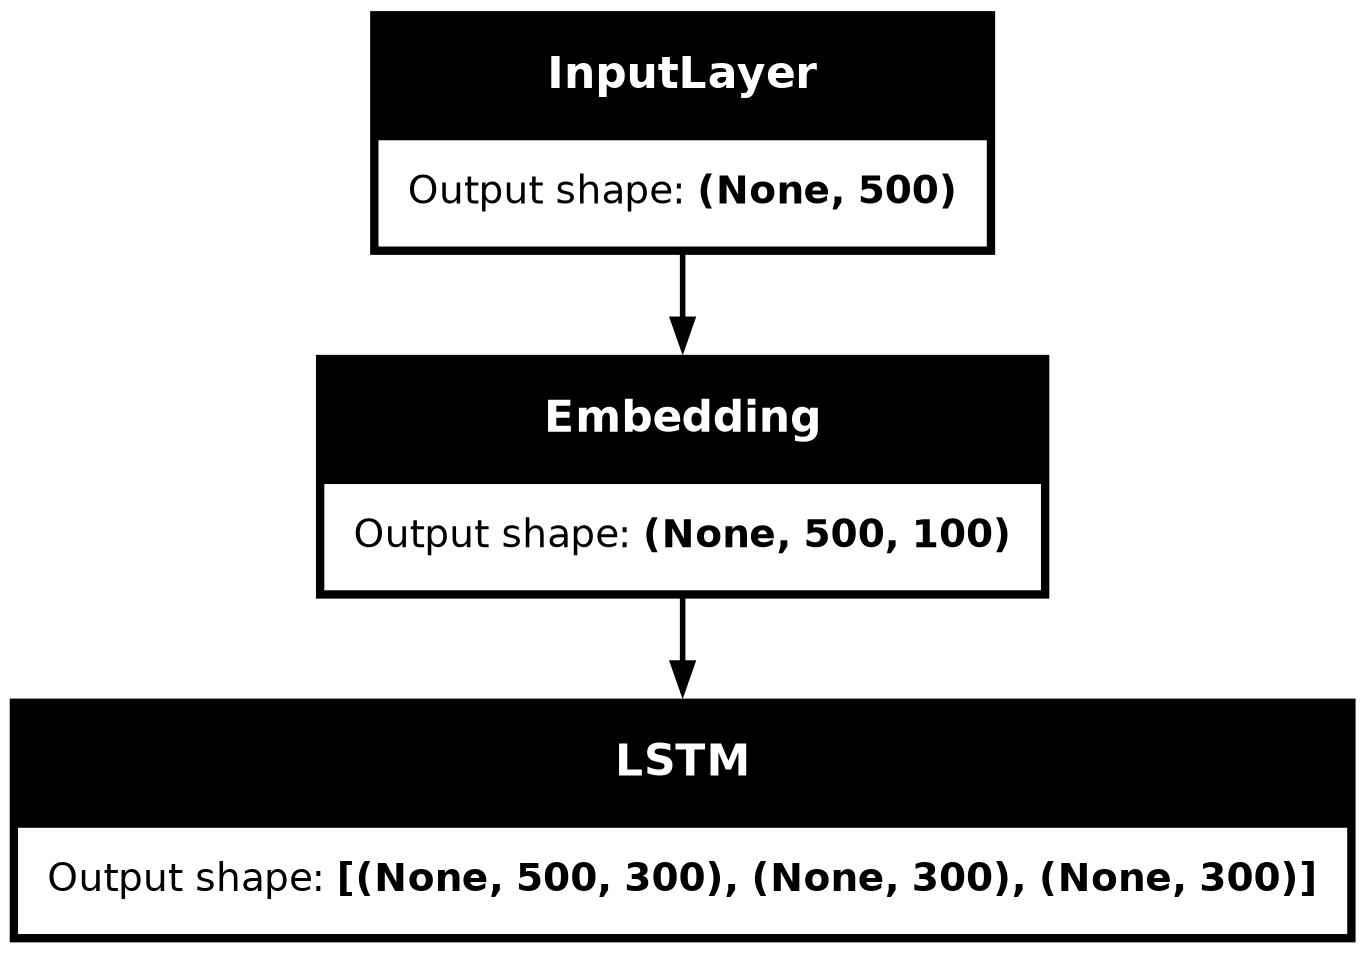

In [91]:
plot_model(infencoder_model,show_shapes=True)

In [92]:
infdecoder_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding_… │ (None, None, 100) │  1,577,500 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ infdec_I1           │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ infdec_I2           │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_LSTM1       │ [(None, None,     │    481,200 │ Decoder_Embeddin… │
│ (LSTM)              │ 300), (None,      │            │ infdec_I1[0][0],  │
│                     │ 300), (None,      │            │ infdec_I2[0][0]   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None,      │  4,748,275 │ Decoder_LSTM1[1]… │
│ (TimeDistributed)   │ 15775)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,806,975 (25.97 MB)

 Trainable params: 6,806,975 (25.97 MB)

 Non-trainable params: 0 (0.00 B)

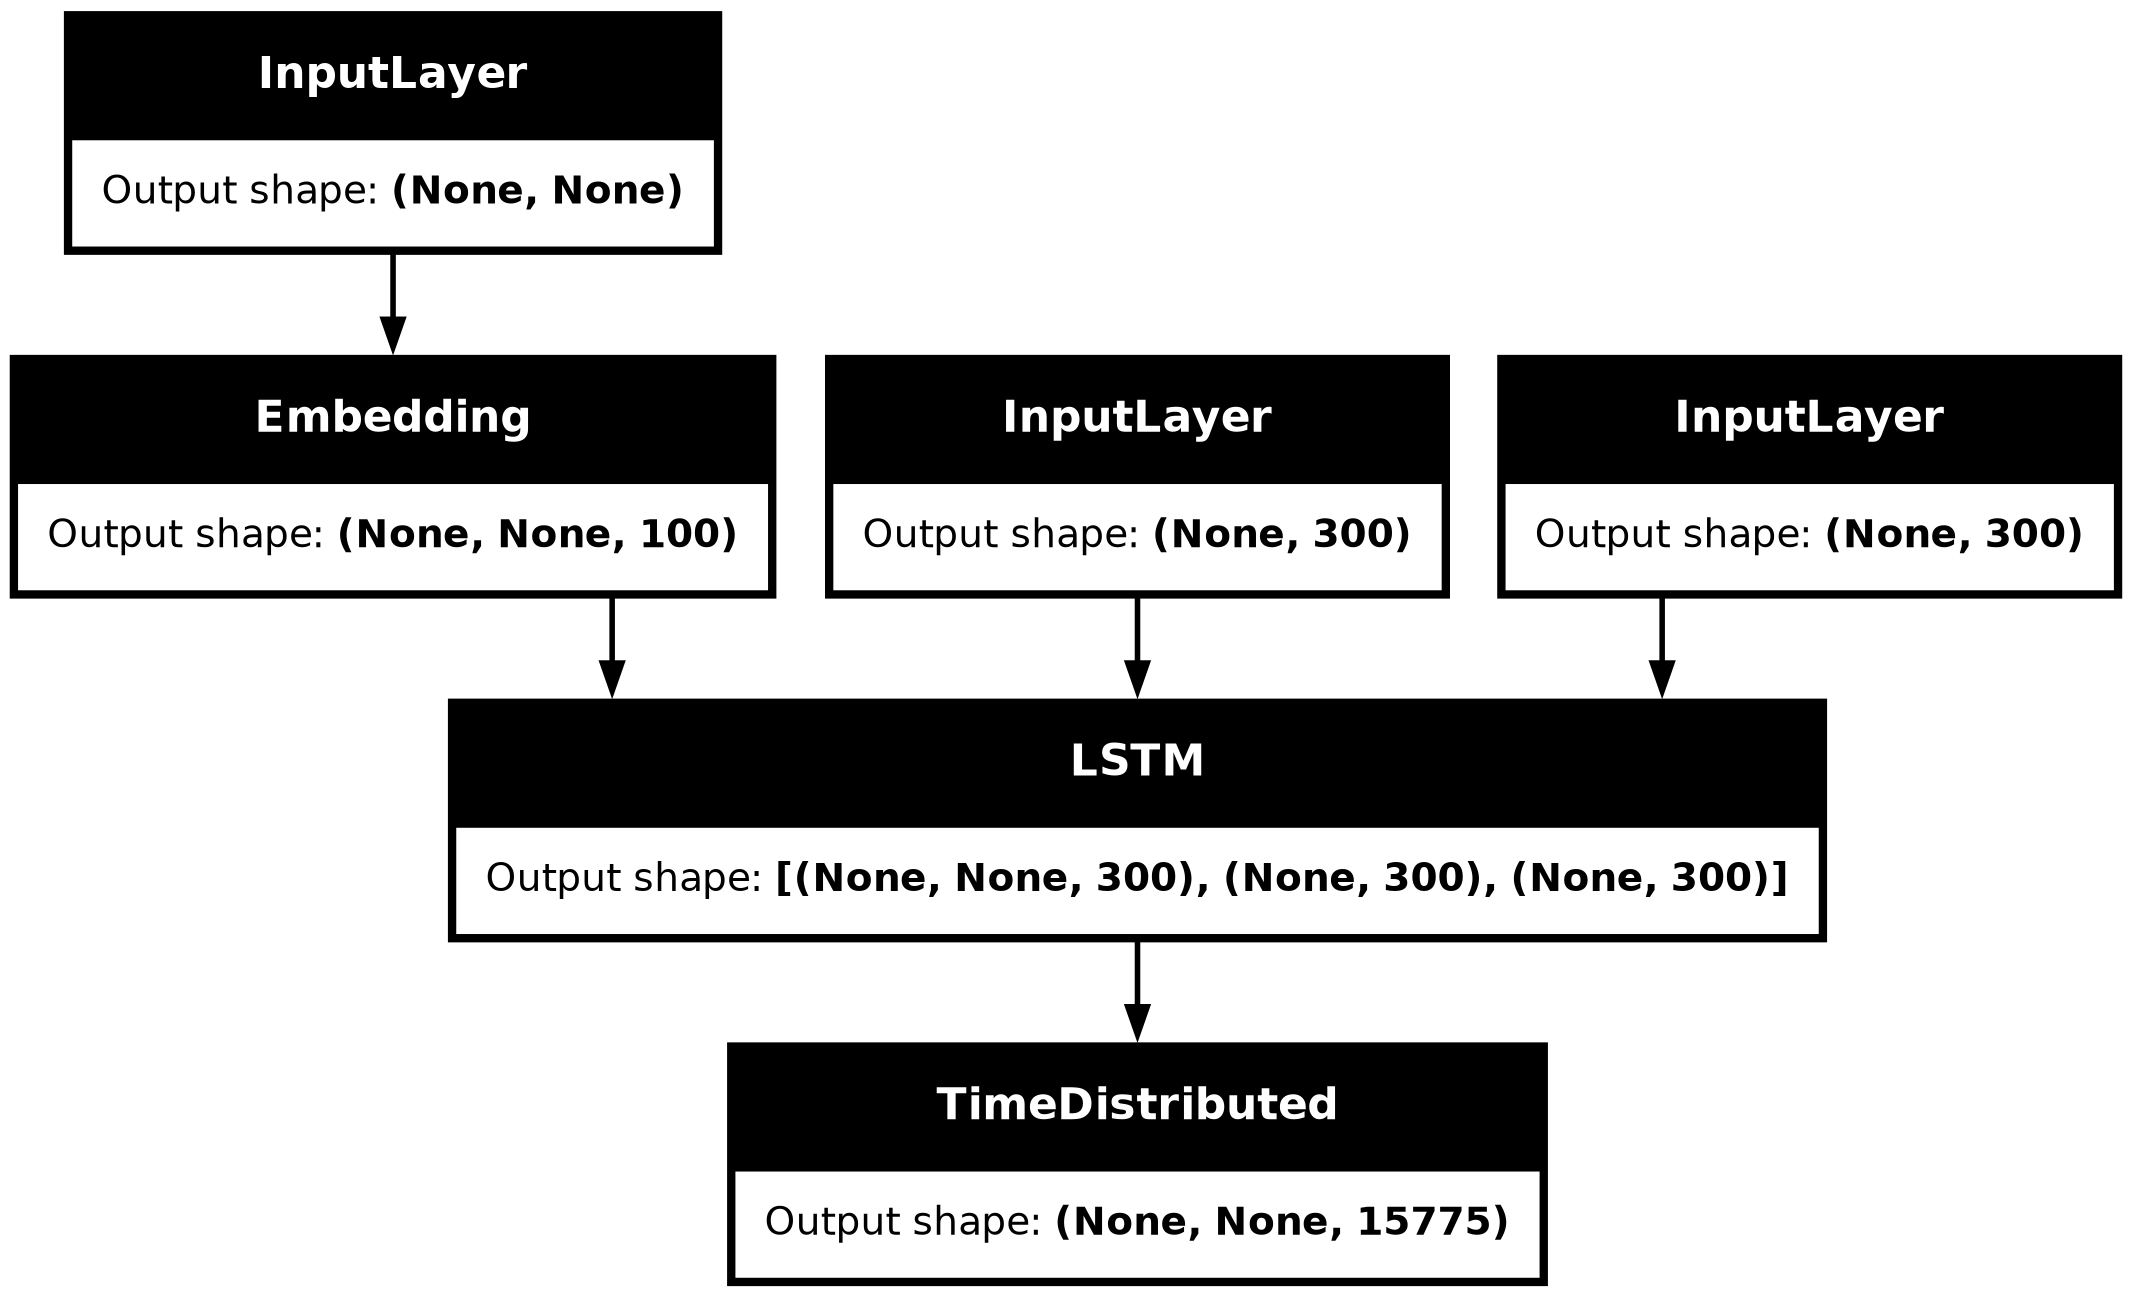

In [93]:
plot_model(infdecoder_model,show_shapes=True)

## Prediction

In [94]:
def decode_sequence(inp_seq):
    
    enc_out,enc_h,enc_c=infencoder_model.predict(inp_seq)
    
    tar_seq=np.zeros((1,1))
    tar_seq[0,0]=sum_wordindex['start']
    
    stop_loop=False
    decoded_string=''
    
    while not stop_loop:
       
        dec_out,dec_h,dec_c=infdecoder_model.predict([tar_seq]+[enc_h,enc_c])
        
        tar_token_index=np.argmax(dec_out[0,-1,:])
        tar_token_word=sum_wordindex[tar_token_index]
        
        if tar_token_word =='end' or len(decoded_string)>=max_art_len:
            
            stop_loop=True
        else:
            decoded_string+=tar_token_word
            
            tar_seq=np.zeros((1,1))
            tar_seq[0,0]=tar_token_index
            
            
            enc_h=dec_h
            enc_c=dec_c
            
    return decoded_string

In [95]:
def seq2art(inp_seq):
    
    art=''
    
    for i in range(len(inp_seq)):
        
        if inp_seq[i]==0:
            break
        art+=reverse_art_index[inp_seq[i]]+' '
        
    return art


def seq2sum(inp_seq):
    
    summary=''
    
    for i in range(len(inp_seq)):
        
        if inp_seq[i]==0:
            break
        word=reverse_sum_index[inp_seq[i]]
        summary+=word+' '
            
    return summary
        

In [96]:
print('Example Articel : '+'\n',seq2art(padded_X_val[2]))
print('Example Summary : '+'\n',seq2sum(padded_Y_val[2]))
print('Predicted Summary : '+'\n',decode_sequence(padded_X_val[2]))

Example Articel : 
 lib dems stress budget trust gappublic trust in the handling of the economy can only be restored if gordon brown opens up his books for unbiased say the lib experts say there is a black hole in the public a claim denied by the lib dem spokesman vince cable said the public did not know who to believe and the national audit office should responding to the mr cable also attacked labour unfair and his mr brown insisted he was on course to meet his golden rule of borrowing only to rather than for over the course of the economic mr cable said people did not know whether to believe the chancellor or the consensus among experts which said the rule would be there is an issue of credibility and he we cannot have a continuation of a situation where the chancellor sets his own tests and then marks what we need is the equivalent of a thorough ofsted inspection of the government he asked what the government had to cable also accused the chancellor of ducking tough he there are se

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_9_1/Cast:0", shape=(32,), dtype=float32). Expected shape (None, 500), but input has incompatible shape (32,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32,), dtype=int32)
  • training=False
  • mask=None